In [ ]:
import os
from diffusers import ( 
    DiffusionPipeline,
    AutoencoderKL,
    StableDiffusionXLPipeline
)
import torch
import numpy as np

from PIL import Image
import torchvision.transforms.functional as F
from diffusers.utils.torch_utils import randn_tensor
import random

model_id = '/data/model/stable-diffusion-xl-base-1.0'
vae_id = '/data/model/sdxl-vae-fp16-fix'
out_dir = 'OUTPUT'

device = 'cuda:6'
vae = AutoencoderKL.from_pretrained(vae_id, torch_dtype=torch.float16)
pipe = StableDiffusionXLPipeline.from_pretrained(
    model_id,
    vae=vae,
    torch_dtype=torch.float16, 
    use_safetensors=True, 
    variant="fp16"
    )

pipe = pipe.to(device)


/c1/sangwon/anaconda3/envs/flux/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]


In [2]:
def bbox_mask(mask_image):
    """
    mask: PIL.Image

    return: list
    """
    # Convert the PIL image to a NumPy array
    mask = np.array(mask_image)

    # Apply a threshold to binarize the mask
    threshold_value = 128  # You might need to adjust this value
    mask_binary = (mask > threshold_value).astype(np.uint8) * 255
    
    # Find the bounding box of the non-zero regions in the binary mask
    rows = np.any(mask_binary, axis=1)
    cols = np.any(mask_binary, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]

    # The bounding box is defined by the coordinates (xmin, ymin) and (xmax, ymax).
    bbox = (xmin, ymin, xmax, ymax)

    return bbox


def image_process(image, mask, margin = 32, fixed_scale=None, size_factor=0.5, out_size=(128, 128), num_subject=3):
    """
    image: PIL.Image
    mask: PIL.Image
    """
    original_size = image.size[0]

    bbox = bbox_mask(mask)
    height, width = bbox[3] - bbox[1], bbox[2] - bbox[0]

    width_per_object = out_size[1]// num_subject
    width_per_object -= width_per_object % 8 # modulo 8

    if fixed_scale is not None:
        rescaling_factor = min((width_per_object - margin) / width, (out_size[0] - margin) / height) * fixed_scale 
    else:
        max_factor = min((width_per_object - margin) / width, (out_size[0] - margin) / height)
        rescaling_factor = np.random.uniform(max_factor * size_factor, max_factor)
    
    new_size = int(original_size * rescaling_factor)

    image = image.resize((new_size, new_size))
    mask = mask.resize((new_size, new_size)) 

    return image, mask

def get_start(seq, margin, width, img_w, num_subjects):
    """
    Same logic you used in tensor_collage, adapted for image width.
    width      = image_map_size[2]
    img_w      = current subject's image width (W dimension)
    """
    if seq == 0:  # left-most subject
        return margin
    elif seq == num_subjects - 1:  # right-most subject
        return width - margin - img_w
    else:
        # center-based positioning for 'middle' subjects
        return (width // (num_subjects * 2)) * (2 * seq + 1) - (img_w // 2)

def image_collage(
    images_,                      # list[dict{'image': PIL.Image, 'mask': PIL.Image}]
    image_map_size=(3, 1024, 1024),
    margin=10,
    height_sync=False,
    device='cpu',
    dtype=torch.float32
):
    """
    Creates a collage of multiple PIL images and their masks.

    Args:
        images_ (list[dict]): Each dict has 'image' (PIL.Image) and 'mask' (PIL.Image).
        image_map_size (tuple): (C, H, W) for final collage.
        margin (int): Max offset for left/right random margin.
        height_sync (bool): If True, all subjects share the same random y-pos.
        device (str): 'cpu' or 'cuda'.
        dtype (torch.dtype): Desired tensor dtype.

    Returns:
        final_collage_pil (PIL.Image): Collaged color image.
        final_mask_pil    (PIL.Image): Collaged union mask (1-channel).
    """
    num_subjects = len(images_)

    # Shuffle the subject order
    idxs = random.sample(range(num_subjects), num_subjects)

    # Convert PIL -> Torch Tensor for each image, mask
    # Using F.to_tensor to get shape (C, H, W) in [0.0, 1.0]
    # or for masks, shape (1, H, W)
    imgs = []
    masks = []
    for idx in idxs:
        pil_img = images_[idx]['image']
        pil_mask = images_[idx]['mask']

        # Convert to Tensor
        tensor_img = F.to_tensor(pil_img).to(device=device, dtype=dtype)
        tensor_mask = F.to_tensor(pil_mask).to(device=device, dtype=dtype)

        # If the mask is RGB or RGBA, you might want to convert it to single-channel
        # For simplicity, F.to_tensor() on a 1-channel PIL mask becomes (1,H,W).
        # We'll keep it as is (1,H,W). We'll broadcast it later when we paste.
        # If it's already (1,H,W), it's fine.
        masks.append(tensor_mask)
        imgs.append(tensor_img)

    # Prepare the blank collage maps
    H, W = image_map_size
    image_map = torch.zeros((3, H, W), device=device, dtype=dtype)
    mask_map = torch.zeros((H, W), device=device, dtype=dtype)

    # Calculate random Y positions (all or each)
    if height_sync:
        # All subjects share the same Y offset
        max_h = max(img.size(1) for img in imgs)
        y_max_sync = H - max_h
        y_sync = random.randint(0, y_max_sync) if y_max_sync > 0 else 0
        y_positions = [y_sync] * num_subjects
    else:
        # Each subject has its own random Y
        y_positions = []
        for img in imgs:
            img_h = img.size(1)
            y_max = H - img_h
            y_pos = random.randint(0, max(0, y_max))
            y_positions.append(y_pos)

    # Random margins in X direction
    left_margin = random.randint(1, margin)
    right_margin = random.randint(1, margin)
    x_margins = (
        [left_margin]
        + [random.randint(-margin, margin) for _ in range(num_subjects - 2)]
        + [right_margin]
    )

    # Determine collage order (i.e., which subject is placed last "on top")
    sequence = random.sample(range(num_subjects), num_subjects)

    for seq in sequence:
        img = imgs[seq]   # shape (C, h, w)
        mask = masks[seq] # shape (1, h, w) or (h, w)
        if mask.dim() == 3 and mask.size(0) == 1:
            # Keep it as (1, h, w) for clarity
            pass

        y_pos = y_positions[seq]
        x_margin = x_margins[seq]

        # Compute valid x_start
        img_h, img_w = img.size(1), img.size(2)
        x_start = get_start(seq, x_margin, W, img_w, num_subjects)

        # 1) Add the mask to the union mask_map
        #    mask_map[y:y+h, x:x+w] += mask (squeezed if needed)
        # Must ensure we slice correctly
        # Also, clamp if out-of-bounds is a concern
        mask_squeezed = mask if mask.dim() == 2 else mask[0]  # shape (h, w)
        mask_map[y_pos : y_pos + img_h, x_start : x_start + img_w] += mask_squeezed

        # 2) Find overlapping region (> 1.5 means we have overlap)
        union_mask = (mask_map > 1.5)

        # 3) Zero out the overlap region in image_map
        image_map[:, union_mask] = 0

        # 4) Paste current subject onto image_map
        #    We want image_map[:, y:y+h, x:x+w] += img * mask
        #    If mask is (1,h,w), we broadcast it across channels
        image_map[
            :,
            y_pos : y_pos + img_h,
            x_start : x_start + img_w
        ] += img * mask

        # 5) Binarize mask_map for next iteration
        mask_map = (mask_map > 0).to(dtype=dtype)

    # convert image_map outer mask region as white
    image_map[:, mask_map == 0] = 255


    # Convert final collage back to PIL
    # image_map is (C,H,W) in [0,1] range, hopefully
    final_collage_pil = F.to_pil_image(image_map.clamp(0, 1).cpu())

    # Also convert mask_map (H,W) to a PIL Image
    # We'll clamp to [0,1], then optionally multiply by 255 for visualization
    # F.to_pil_image expects (1,H,W) or (H,W)
    final_mask_3d = mask_map.unsqueeze(0)  # shape (1,H,W)
    final_mask_pil = F.to_pil_image(final_mask_3d.clamp(0, 1).cpu())

    return final_collage_pil, final_mask_pil 

In [3]:
from functools import partial

def get_timesteps(self, num_inference_steps, strength, device, denoising_start=None):
    # get the original timestep using init_timestep
    if denoising_start is None:
        init_timestep = min(int(num_inference_steps * strength), num_inference_steps)
        t_start = max(num_inference_steps - init_timestep, 0)
    else:
        t_start = 0

    timesteps = self.scheduler.timesteps[t_start * self.scheduler.order :]

    # Strength is irrelevant if we directly request a timestep to start at;
    # that is, strength is determined by the denoising_start instead.
    if denoising_start is not None:
        discrete_timestep_cutoff = int(
            round(
                self.scheduler.config.num_train_timesteps
                - (denoising_start * self.scheduler.config.num_train_timesteps)
            )
        )

        num_inference_steps = (timesteps < discrete_timestep_cutoff).sum().item()
        if self.scheduler.order == 2 and num_inference_steps % 2 == 0:
            # if the scheduler is a 2nd order scheduler we might have to do +1
            # because `num_inference_steps` might be even given that every timestep
            # (except the highest one) is duplicated. If `num_inference_steps` is even it would
            # mean that we cut the timesteps in the middle of the denoising step
            # (between 1st and 2nd devirative) which leads to incorrect results. By adding 1
            # we ensure that the denoising process always ends after the 2nd derivate step of the scheduler
            num_inference_steps = num_inference_steps + 1

        # because t_n+1 >= t_n, we slice the timesteps starting from the end
        timesteps = timesteps[-num_inference_steps:]
        return timesteps, num_inference_steps

    return timesteps, num_inference_steps - t_start

def add_noise(pipe, latents, strength=1.0, noise=None):
    # if pipe has no get_timesteps method
    if not hasattr(pipe, 'get_timesteps'):
        pipe.get_timesteps = partial(get_timesteps, pipe)
    
    num_inference_steps = 50
    device = latents.device
    noise = randn_tensor(latents.shape, device=device, dtype=latents.dtype) if noise is None else noise
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps, _ = pipe.get_timesteps(
        num_inference_steps,
        strength,
        device,
        denoising_start=None,
    )
    latent_timestep = timesteps[:1]
    # scaled_latents = latents * pipe.vae.config.scaling_factor
    return pipe.scheduler.add_noise(latents, noise, latent_timestep)

In [4]:
all_subject_dict = {
    'actionfigure_2': ('olis harry potter toy', 'a02'),
    'can': ('hta blue drink can', 'b00'),
    'monster_toy': ('ult red monster plush', 'c01'),
    'robot_toy': ('amg white robot toy', 'd00'),
    'bear_plushie': ('lun beige teddy bear', 'e03'),
}

img_path_base = 'dataset/category/count_ablation'

In [8]:
out_size = (768, 1344)

concepts = list(all_subject_dict.keys())[1:]

scales = [0.65, 0.8, 0.75, 0.75]

images_ = []
TOK = []
for i, concept in enumerate(concepts):
    name, img_name = all_subject_dict[concept]
    TOK.append(name)
    image = Image.open(os.path.join(img_path_base, f'{img_name}.jpg'))
    if image.mode != 'RGB':
        image = image.convert('RGB')
    mask = Image.open(os.path.join(img_path_base, f'mask_{img_name}.jpg'))
    image, mask = image_process(image, mask, margin=16, fixed_scale=scales[i], size_factor=1, out_size=out_size, num_subject=len(concepts))
    images_.append({
        'image': image,
        'mask': mask
    })

bg, mask = image_collage(images_, out_size, margin=32, height_sync=False, device=device, dtype=torch.float16)
mask_ = mask.resize((mask.size[0] // 8, mask.size[1] // 8))
    
mask_ = np.array(mask_) > 0
mask_binary = torch.tensor(mask_).to(device=device)
with torch.no_grad():
    out = pipe.vae.encode(pipe.image_processor.preprocess(bg).to(device, torch.float16)).latent_dist.sample()
init_latent = out * mask_binary.to(out.dtype)

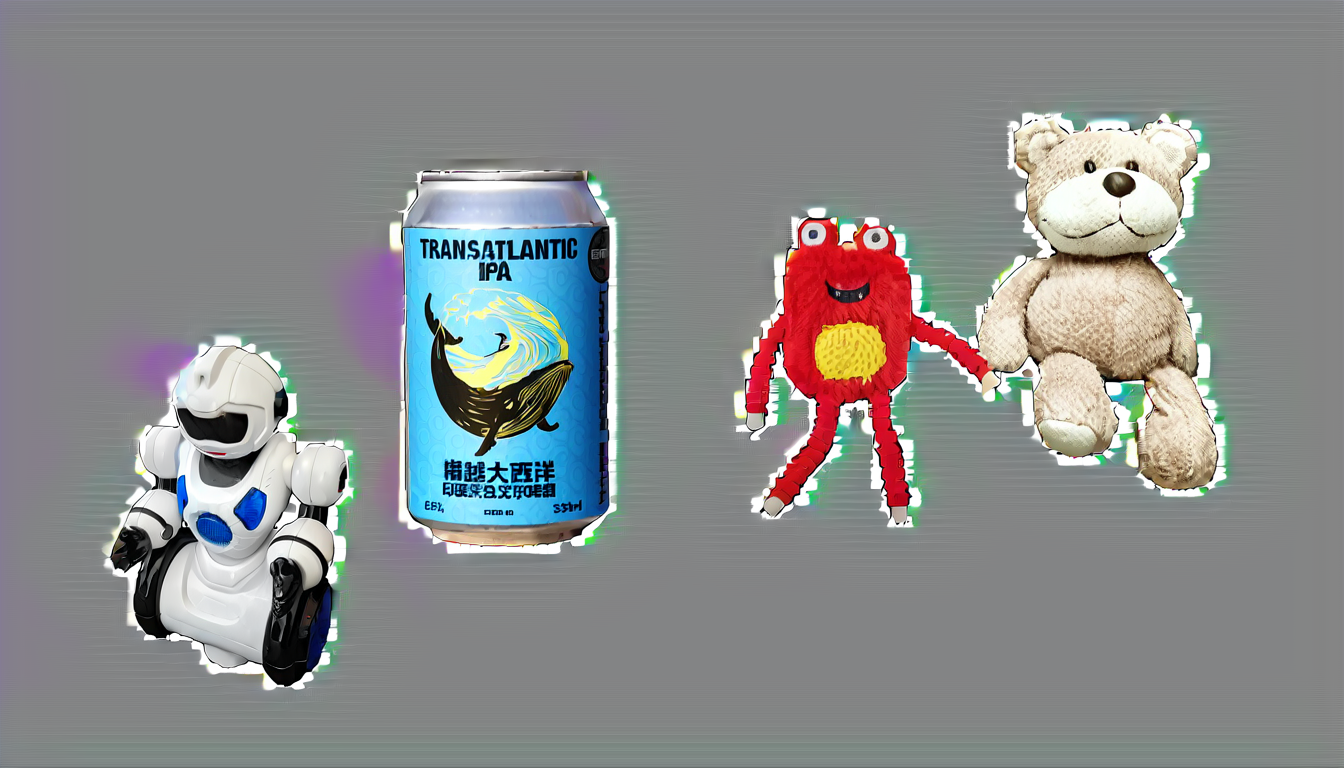

In [9]:
# visualize
with torch.no_grad():
    image = pipe.vae.decode(init_latent, return_dict=False)[0]    
    image = pipe.image_processor.postprocess(image, output_type='pil')
image[0]

In [10]:
pipe.unload_lora_weights()
pipe.load_lora_weights("output/segmix/count_ablation/five_subjects_p05_s0/save-10000")

100%|██████████| 50/50 [00:17<00:00,  2.83it/s]


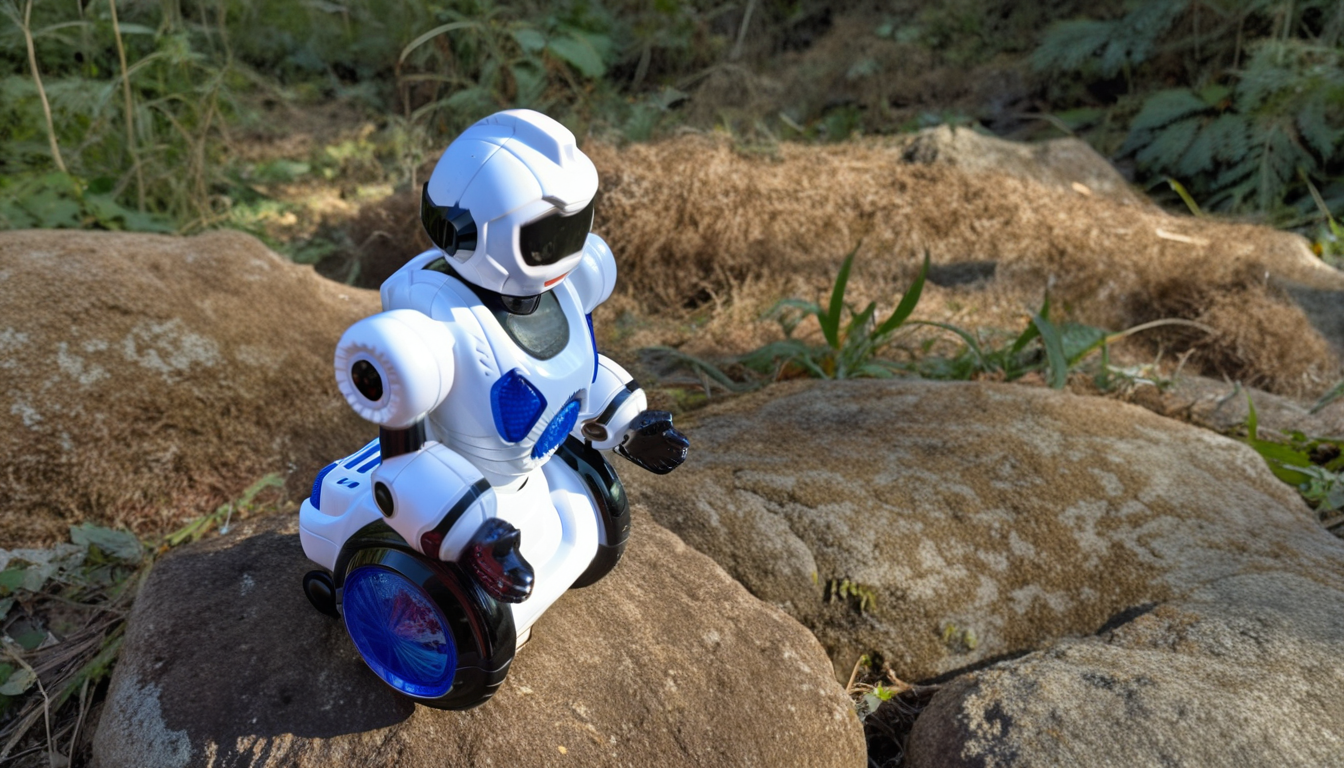

In [13]:
# w/o our Inference
prompt = 'Four objects: amg white robot toy, lun beige teddy bear, hta blue drink can, and ult red monster toy are in the jungle, 4K, high quality'
negative_prompt = "sticker, collage, anime, cartoon, graphic, text, painting, crayon, graphite, abstract glitch, blurry"
seed = 0
generator = torch.Generator(device=device).manual_seed(seed)

noise = randn_tensor(init_latent.shape, device=pipe.unet.device, dtype=torch.float16, generator=generator)
init_latent_ = noise
img = pipe(prompt=prompt, negative_prompt=negative_prompt, 
           latents=init_latent_, cross_attention_kwargs={'scale': 1}).images[0]
img

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


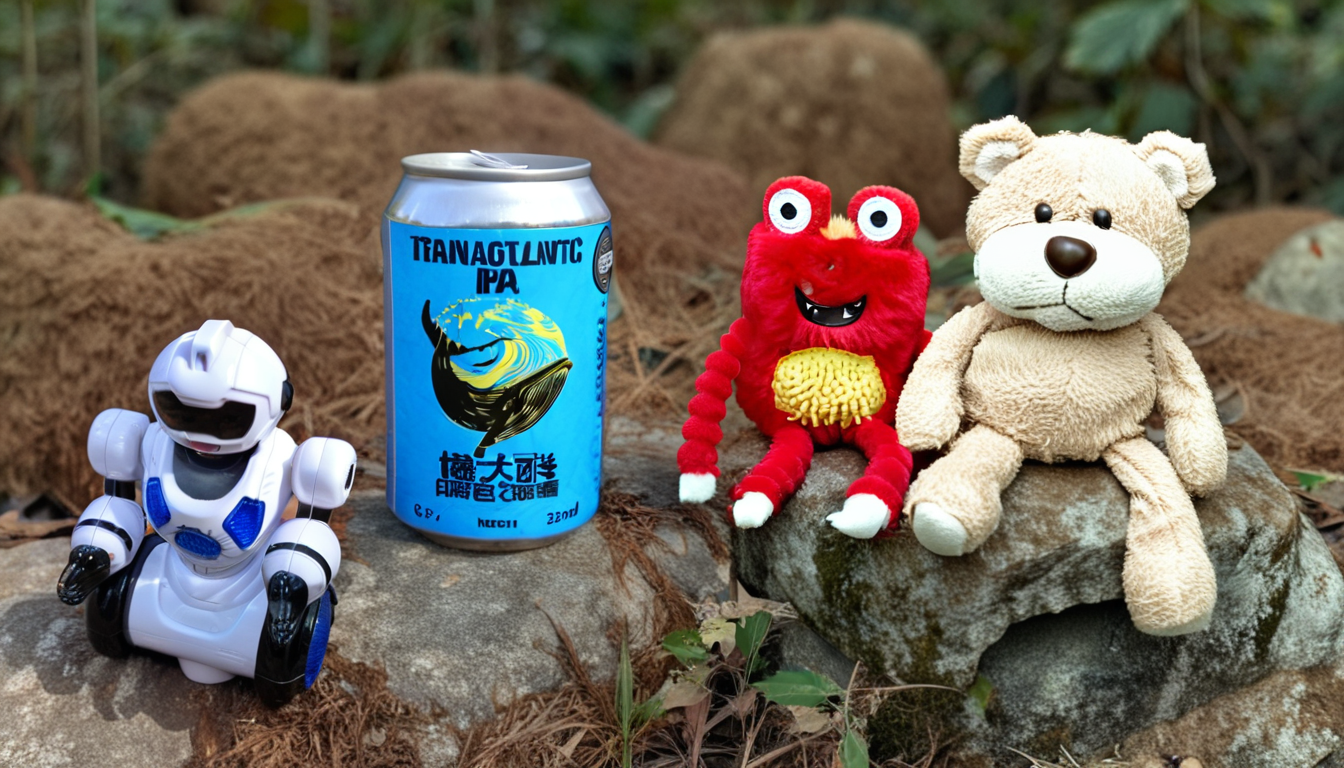

In [14]:
# w/ our Inference
gamma = 3
generator = torch.Generator(device=device).manual_seed(seed)

noise = randn_tensor(init_latent.shape, device=pipe.unet.device, dtype=torch.float16, generator=generator)
init_latent_ = add_noise(pipe, pipe.vae.config.scaling_factor * init_latent * gamma, strength=1., noise=noise)
init_latent_ /= pipe.scheduler.init_noise_sigma

img = pipe(prompt=prompt, negative_prompt=negative_prompt, 
           latents=init_latent_, cross_attention_kwargs={'scale': 1}).images[0]
img